In [1]:
!nvidia-smi

Wed Sep 14 17:25:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:06.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |   2402MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


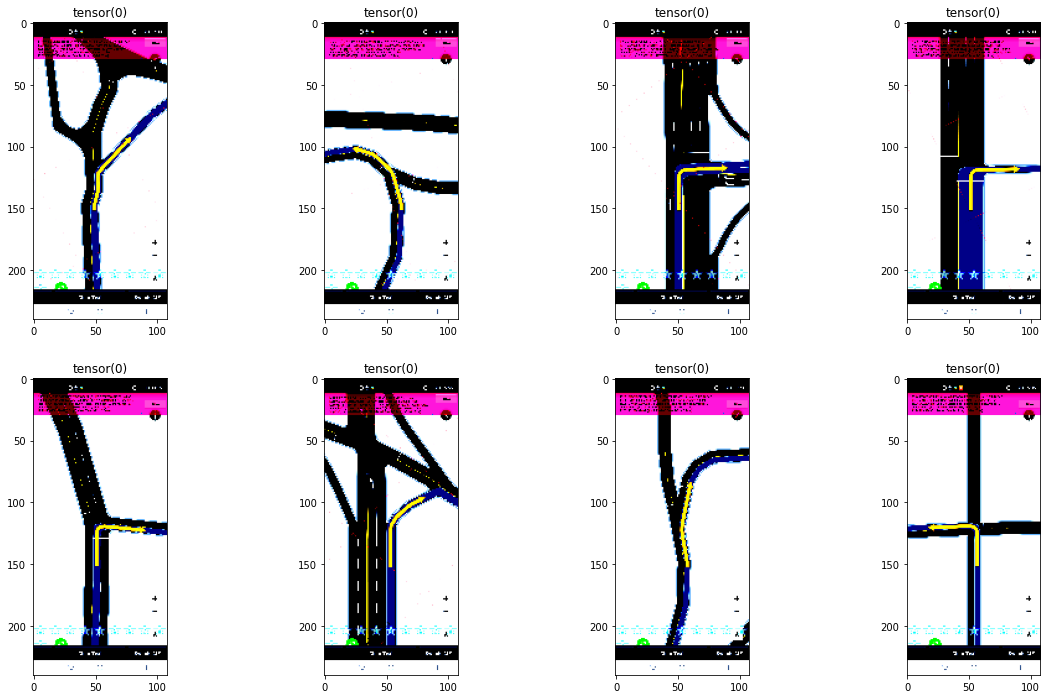

GPU is available, train on GPU


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


	 fc.0.weight
	 fc.0.bias
1/3
this is train process
Time cost  34.0 min 31.0264630317688 s
train loss:2002.4576 Acc:0.8505
this is valid process
Time cost  40.0 min 13.31825852394104 s
valid loss:355.9118 Acc:0.8600
Optimizer learning rate : 0.0100000

2/3
this is train process
Time cost  74.0 min 32.09960222244263 s
train loss:2082.1986 Acc:0.8608
this is valid process
Time cost  80.0 min 9.196325063705444 s
valid loss:287.2665 Acc:0.9078
Optimizer learning rate : 0.0100000

3/3
this is train process
Time cost  114.0 min 22.266072034835815 s
train loss:2092.8605 Acc:0.8613
this is valid process
Time cost  120.0 min 0.8497114181518555 s
valid loss:378.9391 Acc:0.9022
Optimizer learning rate : 0.0100000

Training complete in 120m 1s
Best val Acc: 0.907759


ValueError: Length of values (10000) does not match length of index (1250)

In [1]:
# -*- coding:utf-8 -*-
"""
1 一张图片存在多个问题的处理
2 未标签数据怎么利用
3 标签数据中0类数据太多
"""
import os
import time
import copy
from PIL import Image
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torchvision import transforms,models
import matplotlib.pyplot as plt

# df=pd.read_csv(r'D:\迅雷下载\2022_2_data\train_label\train_label.csv',header=None,names=[1,2,3,4,5],
#                )
# # error_bad_lines=False 这样直接删除了出现错误的列（包含两个以上，的列）
# df.head(3).append(df.tail(3))
# y=df.iloc[:,1]

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Resize((240,108)),
                              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                              ])


class Mydata(Dataset):
    def __init__(self,path,label_path):
        self.path=path
        self.path_list=os.listdir(self.path)
        self.path_label=label_path
        if self.path_label is not None:
            df = pd.read_csv(self.path_label, header=None, names=[1, 2, 3, 4, 5])
            self.y = df.iloc[:, 1]

    def __getitem__(self, item):
        names=self.path_list[item]
        img_name=os.path.join(self.path, names)
        img=Image.open(img_name)
        img = img.convert("RGB")
        # label
        if self.path_label is not None:
            return transform(img), torch.tensor(self.y[item])
        else:
            return transform(img)

    def __len__(self):
        return len(self.path_list)

def im_convert(tensor):
    """展示"""
    image=tensor.to("cpu").clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1,2,0)
    # image=image.clip(0,1)   # numpy.clip(a, a_min, a_max, out=None) 将数组中的元素限制在a_min, a_max之间

    return image


train_path=r'hy-tmp/huawei-b/train_image'
valid_path=r'hy-tmp/huawei-b/valid_image'
train_label=r'hy-tmp/huawei-b/train_labels.csv'
valid_label=r'hy-tmp/huawei-b/valid_labels.csv'
batch_size=8

train_data=Mydata(train_path,train_label)
valid_data=Mydata(valid_path,valid_label)


# print(train_data[0])
# print(train_data[1])
# print(type(train_data[0]))
# print(train_data[0][0].size())

train_loader=DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,drop_last=True)
valid_loader=DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=True,drop_last=True)


fig=plt.figure(figsize=(20,12))
columns=4
rows=2
dataiter=iter(train_loader)
inputs, classes=dataiter.next()

for idx in range(columns*rows):
    ax=fig.add_subplot(rows,columns,idx+1)
    n = classes[idx]   #  n:tensor(62)
    ax.set_title(n)
    plt.imshow(im_convert(inputs[idx]))
plt.show()

data_loaders={'train':train_loader,'valid':valid_loader}


model_name='resnet'
feature_extract=True   # 是否用别人训练好的
train_on_gpu=torch.cuda.is_available()
if not train_on_gpu:
    print("GPU is not available, train on CPU")
else:
    print("GPU is available, train on GPU")

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_parameter_requires_grad(model,feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad=False

model_ft=models.resnet152()
model_ft

def initialize_model(model_name,num_classes,feature_extract,use_pretrained=True):
    if model_name=='resnet':
        model_ft=models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)   # 是否冻住前面
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes),
                                   nn.LogSoftmax(dim=1))
        input_size = 224

    return model_ft,input_size

model_ft,input_size=initialize_model('resnet',8,feature_extract)
model_ft=model_ft.to(device)
filename='checkpoint.pth'
para_learn=model_ft.parameters()
if feature_extract:
    para_learn=[]
    for name,parameter in model_ft.named_parameters():
        if parameter.requires_grad==True:
            para_learn.append(parameter)
            print('\t', name)
else:
    for name,pare in model_ft.named_parameters():
        if pare.requires_grad==True:
            print('\t',name)

optimizer_ft=optim.Adam(para_learn,lr=1e-2)
scheduler=optim.lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)
criterion=nn.NLLLoss()

def train_model(models,dataloader,criterion,optimizer,num_epochs=25,filename=filename):
    start=time.time()
    best_acc=0
    best_model_wts=copy.deepcopy(models.state_dict())
    train_loss=[]
    valid_loss=[]
    train_acc=[]
    valid_acc=[]
    models=models.to(device)
    LRs = [optimizer.param_groups[0]['lr']]

    for epoch in range(num_epochs):
        print('{}/{}'.format(epoch+1,num_epochs))
        for phase in ['train','valid']:
            if phase =='train':
                models.train()
                print('this is train process')
            else:
                models.eval()
                print('this is valid process')
            running_loss = 0
            running_acc = 0

            for inputs, label in dataloader[phase]:
                inputs = inputs.to(device)
                # [8, 3, 240, 108])
                label =label.to(device)
                outputs=models(inputs)
                optimizer.zero_grad()
                loss=criterion(outputs,label)
                _,pred=torch.max(outputs,1)
                if phase =='train':
                    loss.backward()
                    optimizer.step()


                running_loss+=loss.item()
                running_acc+=torch.sum(pred==label.data)
            epoch_loss=running_loss/num_epochs
            epoch_acc=running_acc.double()/len(dataloader[phase].dataset)
            time_cost=time.time()-start
            print('Time cost ',time_cost//60,'min',time_cost % 60,'s')
            print('{} loss:{:.4f} Acc:{:.4f}'.format(phase,epoch_loss,epoch_acc))
# this

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(models.state_dict())
                state = {
                    'state_dict': models.state_dict(),
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                valid_acc.append(epoch_acc)
                valid_loss.append(epoch_loss)
                scheduler.step()
            if phase == 'train':
                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)

        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()


    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    models.load_state_dict(best_model_wts)
    return models, valid_acc, train_acc, valid_loss, train_loss, LRs

model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(
    model_ft, data_loaders, criterion, optimizer_ft, num_epochs=3)


"""
预测新的图片
"""
# pred=[]
# test_path=r'hy-tmp/huawei-b/test_images'
# test_label=None
# test_data=Mydata(test_path,test_label)
# train_loader=DataLoader(dataset=test_data,batch_size=batch_size,drop_last=True)

# for dataiter in iter(train_loader):
#     images = dataiter

#     model_ft.eval()

#     if train_on_gpu:
#         output = model_ft(images.cuda())
#     else:
#         output = model_ft(images)

#     _, preds_tensor = torch.max(output, 1)

#     preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
#     pred.append(preds)

# test_label=pd.DataFrame(pred)
# test_names=os.listdir(r'hy-tmp/huawei-b/test_images')
# test_label.insert(0,'image_name',test_names)
# test_label.to_csv('test_label',index=None,header=None)


In [2]:
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [4]:
pred=[]
test_path=r'hy-tmp/huawei-b/test_images'
test_label=None
test_data=Mydata(test_path,test_label)
train_loader=DataLoader(dataset=test_data,batch_size=batch_size,drop_last=True)

for dataiter in iter(train_loader):
    images = dataiter

    model_ft.eval()

    if train_on_gpu:
        output = model_ft(images.cuda())
    else:
        output = model_ft(images)

    _, preds_tensor = torch.max(output, 1)

    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    pred.extend(preds)


test_names=os.listdir(r'hy-tmp/huawei-b/test_images')
test_label=pd.DataFrame(test_names)
test_label['1']=pred

test_label.to_csv('submit.csv',index=None,header=None)

In [5]:
# 查看环境

In [12]:
import platform
print ('python版本',platform.python_version())
print('pytorch+cuda版本',torch.__version__)

python版本 3.8.10
pytorch+cuda版本 1.12.0+cu113
